In [0]:
""" Classifying flowers with MobileNet Model and Inception Model using Transfer Learning """

try:
  %tensorflow_version 2.x
except:
  pass

# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import logging
tf.get_logger().setLevel(logging.ERROR)
import tensorflow_hub as hub

In [0]:
# Training and Validation Sets
splits = tfds.Split.ALL.subsplit(weighted=(70,30))
(train_dataset,validation_dataset),info = tfds.load('tf_flowers',
                                                   split=splits,
                                                   as_supervised=True,
                                                   with_info=True)
num_classes = info.features['label'].num_classes
num_training_examples, num_validation_examples = 0,0
for example in train_dataset:
    num_training_examples += 1
for example in validation_dataset:
    num_validation_examples += 1

In [46]:
print(num_classes,num_training_examples,num_validation_examples)

5 2590 1080


In [0]:
# Preparing batches of dataset
image_size = 224
def format_image(image,label):
  image = tf.image.resize(image,(image_size,image_size))/255.0
  return image,label

batch_size = 32
train_batches = train_dataset.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_dataset.map(format_image).batch(batch_size).prefetch(1)

In [0]:
# Importing MobileNet model
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(image_size,image_size,3), trainable=False)

In [49]:
# Model building
model = tf.keras.Sequential([
                             feature_extractor,
                             tf.keras.layers.Dense(num_classes,activation="softmax")
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [50]:
# Compiling and training the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

epochs = 6

history = model.fit(train_batches, 
                    epochs = epochs, 
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 10s 125ms/step - loss: 0.8061 - accuracy: 0.6961 - val_loss: 0.5096 - val_accuracy: 0.8231
Epoch 2/6
81/81 [==============================] - 8s 93ms/step - loss: 0.3653 - accuracy: 0.8834 - val_loss: 0.4266 - val_accuracy: 0.8491
Epoch 3/6
81/81 [==============================] - 8s 99ms/step - loss: 0.2898 - accuracy: 0.9077 - val_loss: 0.3702 - val_accuracy: 0.8713
Epoch 4/6
81/81 [==============================] - 7s 92ms/step - loss: 0.2333 - accuracy: 0.9259 - val_loss: 0.3532 - val_accuracy: 0.8833
Epoch 5/6
81/81 [==============================] - 8s 95ms/step - loss: 0.1964 - accuracy: 0.9444 - val_loss: 0.3528 - val_accuracy: 0.8824
Epoch 6/6
81/81 [==============================] - 8s 95ms/step - loss: 0.1727 - accuracy: 0.9517 - val_loss: 0.3329 - val_accuracy: 0.8843


Text(0.5, 0.98, 'MobileNet Model')

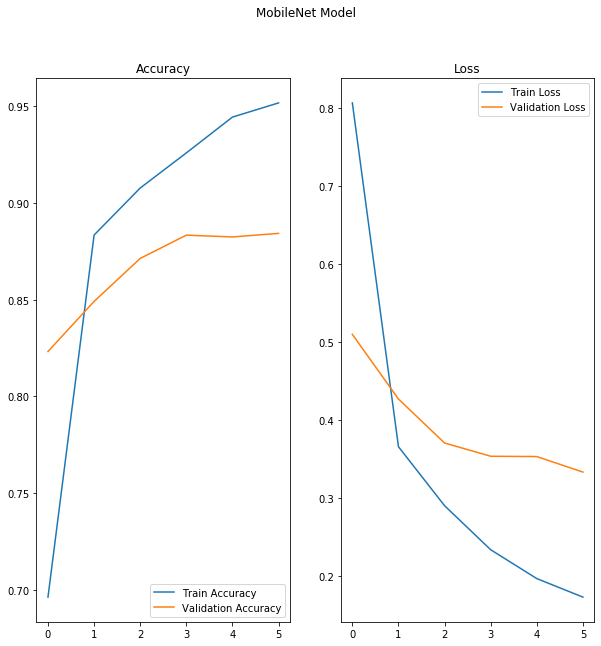

In [51]:
# Plotting Training and Validation Accuracy
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label="Train Accuracy")
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label="Train Loss")
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.suptitle("MobileNet Model")

In [52]:
class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [53]:
# Verifying the results
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch, label_batch = image_batch.numpy(), label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch,axis=-1)

labels_path = tf.keras.utils.get_file("ImageNet Labels","https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt")
imagenet_labels = np.array(open(labels_path).read().splitlines())

predicted_class_names = imagenet_labels[predicted_ids]
print(predicted_class_names)

['background' 'background' 'goldfish' 'goldfish' 'background' 'tench'
 'tiger shark' 'goldfish' 'background' 'goldfish' 'tench' 'background'
 'goldfish' 'background' 'goldfish' 'goldfish' 'background' 'tiger shark'
 'tench' 'tench' 'great white shark' 'tiger shark' 'background'
 'tiger shark' 'great white shark' 'goldfish' 'background' 'goldfish'
 'background' 'tiger shark' 'tiger shark' 'tench']


In [54]:
print(label_batch)
print(predicted_ids)

[0 0 2 2 0 1 4 2 0 2 1 0 2 0 2 2 0 4 1 1 3 4 0 4 3 2 0 2 0 4 4 1]
[0 0 2 2 0 1 4 2 0 2 1 0 2 0 2 2 0 4 1 1 3 4 0 4 3 2 0 2 0 4 4 1]


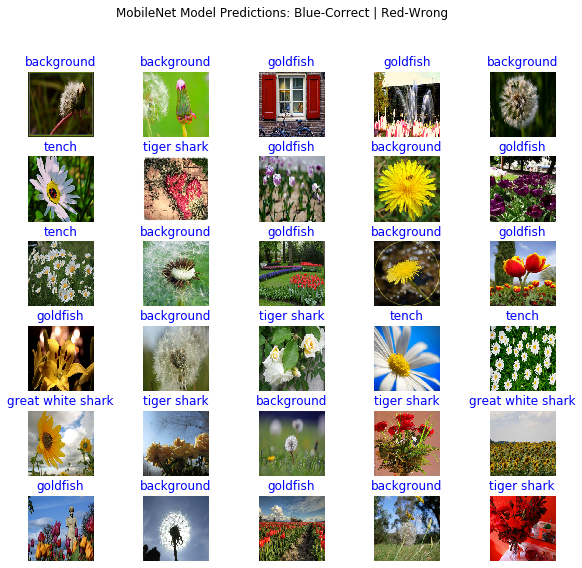

In [55]:
plt.figure(figsize=(10,9))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[i])
  color = "blue" if predicted_ids[i] == label_batch[i] else "red"
  plt.title(predicted_class_names[i],color = color)
  plt.axis('off')
_ = plt.suptitle("MobileNet Model Predictions: Blue-Correct | Red-Wrong")

In [0]:
# Importing Inception model
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(299,299,3), trainable=False)

In [57]:
# Inception Model building
model_inc = tf.keras.Sequential([
                             feature_extractor,
                             tf.keras.layers.Dense(num_classes,activation="softmax")
])
model_inc.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [58]:
# Compiling and training the model
model_inc.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

epochs = 6

def format_image(image,label):
  image = tf.image.resize(image,(299,299))/255.0
  return image,label

train_batches = train_dataset.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_dataset.map(format_image).batch(batch_size).prefetch(1)

history = model_inc.fit(train_batches, 
                    epochs = epochs, 
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 20s 241ms/step - loss: 0.7048 - accuracy: 0.7483 - val_loss: 0.5112 - val_accuracy: 0.8093
Epoch 2/6
81/81 [==============================] - 16s 203ms/step - loss: 0.3773 - accuracy: 0.8784 - val_loss: 0.4000 - val_accuracy: 0.8593
Epoch 3/6
81/81 [==============================] - 17s 204ms/step - loss: 0.2865 - accuracy: 0.9174 - val_loss: 0.3655 - val_accuracy: 0.8722
Epoch 4/6
81/81 [==============================] - 16s 199ms/step - loss: 0.2423 - accuracy: 0.9274 - val_loss: 0.3449 - val_accuracy: 0.8806
Epoch 5/6
81/81 [==============================] - 16s 198ms/step - loss: 0.2145 - accuracy: 0.9425 - val_loss: 0.3471 - val_accuracy: 0.8843
Epoch 6/6
81/81 [==============================] - 16s 199ms/step - loss: 0.1884 - accuracy: 0.9494 - val_loss: 0.3249 - val_accuracy: 0.8889


Text(0.5, 0.98, 'Inception Model')

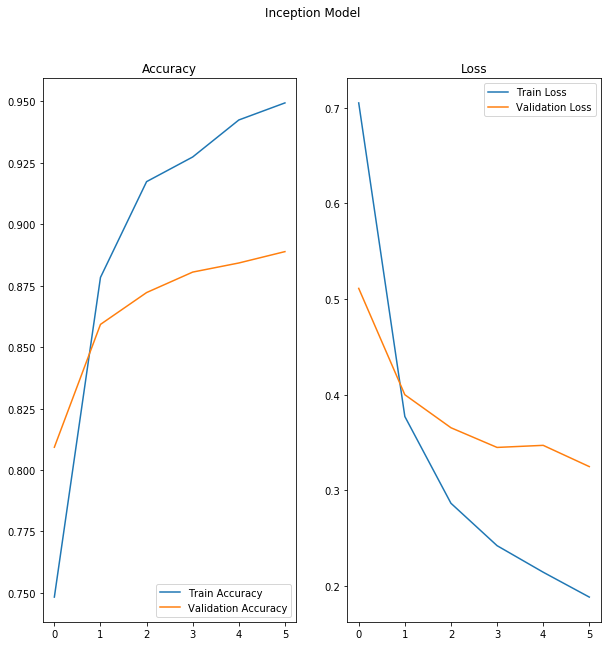

In [63]:
# Plotting Training and Validation Accuracy
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label="Train Accuracy")
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label="Train Loss")
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.suptitle("Inception Model")

In [64]:
# Verifying the results
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch, label_batch = image_batch.numpy(), label_batch.numpy()

predicted_batch = model_inc.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch,axis=-1)

labels_path = tf.keras.utils.get_file("ImageNet Labels","https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt")
imagenet_labels = np.array(open(labels_path).read().splitlines())

predicted_class_names = imagenet_labels[predicted_ids]
print(predicted_class_names)

['tiger shark' 'background' 'background' 'tench' 'background' 'background'
 'tiger shark' 'goldfish' 'goldfish' 'great white shark' 'goldfish'
 'background' 'goldfish' 'background' 'goldfish' 'great white shark'
 'background' 'goldfish' 'great white shark' 'goldfish'
 'great white shark' 'tench' 'goldfish' 'tiger shark' 'goldfish'
 'great white shark' 'great white shark' 'goldfish' 'background'
 'tiger shark' 'goldfish' 'goldfish']


In [65]:
print(label_batch)
print(predicted_ids)

[4 0 3 1 0 0 4 2 2 3 2 0 2 0 2 3 0 2 3 2 3 1 2 4 2 3 3 2 0 1 2 2]
[4 0 0 1 0 0 4 2 2 3 2 0 2 0 2 3 0 2 3 2 3 1 2 4 2 3 3 2 0 4 2 2]


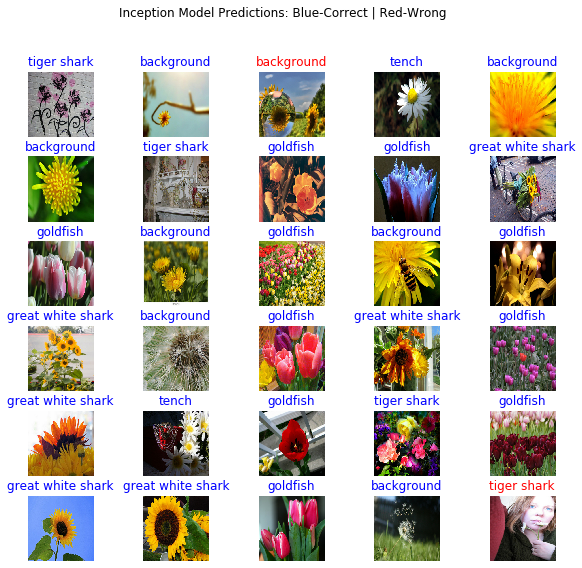

In [66]:
# Inception Model Results
plt.figure(figsize=(10,9))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[i])
  color = "blue" if predicted_ids[i] == label_batch[i] else "red"
  plt.title(predicted_class_names[i],color = color)
  plt.axis('off')
_ = plt.suptitle("Inception Model Predictions: Blue-Correct | Red-Wrong")
# Looking at the results, MobileNet model seems to be more suitable for this application